In [42]:
import pyemma
import pickle
import os
import glob
import torch

import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np

np.bool = np.bool_

from tqdm import tqdm
from matplotlib.colors import LogNorm
from itertools import combinations

blue = (70 / 255, 110 / 255, 250 / 255)
green = (100 / 255, 170 / 255, 120 / 255)

molecule = "2JOF"
simulation_idx = 0
base_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein"
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/notebook/{molecule}_from_mae.pdb"

# Visualization

In [43]:
# PDB

pdb_traj = md.load_pdb(pdb_path)
pdb_view = nv.show_mdtraj(
    pdb_traj,
    height="400px",
    width="400px"
)
pdb_view.add_representation("licorice", selection="protein")

print(pdb_traj)
pdb_view

<mdtraj.Trajectory with 1 frames, 272 atoms, 20 residues, without unitcells>


NGLWidget()

In [3]:
# Count the number of .dcd files in the simulation directory
dcd_pattern = f"{base_dir}/{molecule}-{simulation_idx}-protein-*.dcd"
dcd_files = glob.glob(dcd_pattern)
num_files = len(dcd_files)

print(f"Found {num_files} .dcd files in {base_dir}")
print(f"Pattern used: {dcd_pattern}")

# Extract the indices from filenames and sort them
file_indices = []
for file_path in dcd_files:
    filename = os.path.basename(file_path)
    # Extract the index from filename like "2JOF-0-protein-000.dcd"
    index_part = filename.split('-')[-1].replace('.dcd', '')
    if index_part.isdigit():
        file_indices.append(int(index_part))

file_indices.sort()
print(f"File indices range: {min(file_indices)} to {max(file_indices)}")
print(f"Total files to load: {len(file_indices)}")

Found 105 .dcd files in /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein
Pattern used: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-*.dcd
File indices range: 0 to 104
Total files to load: 105


In [4]:
# Load trajectories using the actual file indices found
traj_list = []
for i in tqdm(
    file_indices,
    desc="Loading trajectories"
):
    file_idx = f"{i:03d}"
    file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}.dcd"
    # print(file_path)
    # Check if file exists before loading
    if os.path.exists(file_path):
        traj = md.load_dcd(file_path, top=pdb_path)
        traj_list.append(traj)
    else:
        print(f"Warning: File not found: {file_path}")

print(f"Successfully loaded {len(traj_list)} trajectory files")
all_traj = md.join(traj_list)

Loading trajectories: 100%|██████████| 105/105 [00:03<00:00, 30.11it/s]


Successfully loaded 105 trajectory files


In [44]:
view = nv.show_mdtraj(
    all_traj,
	height="400px",
    width="400px"
)
view.add_representation("licorice", selection="protein")
print(f"Total frames: {all_traj.n_frames}")
view

Total frames: 1044000


NGLWidget(max_frame=1043999)

In [10]:
view.frame = 24623

# Descriptors

In [ ]:
pdb = md.load(pdb_path)
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb.topology.residues), 2)]
)
ca_pair_contacts, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)

print(ca_pair_contacts.shape)
print(ca_pair_contacts.mean())

# ca_pair_contacts = torch.from_numpy(ca_pair_contacts)
# torch.save(ca_pair_contacts, f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance.pt")

(1044000, 190)
1.1409878


In [11]:
type(ca_pair_contacts)

torch.Tensor

In [13]:
exp = torch.tensor(2)
ca_pair_distances_swtich = (1 - (torch.pow(ca_pair_contacts, exp) / 0.8)) / (1 - (torch.pow(ca_pair_contacts, exp) / 0.8))
print(ca_pair_distances_swtich.shape)
print(ca_pair_distances_swtich.mean())
torch.save(ca_pair_distances_swtich, f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance-switch.pt")

torch.Size([1044000, 190])
tensor(1.)


In [14]:
xyz = all_traj.xyz
print(xyz.shape)

torch.save(torch.from_numpy(xyz), f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos-nano.pt")

(1044000, 272, 3)


# TICA

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

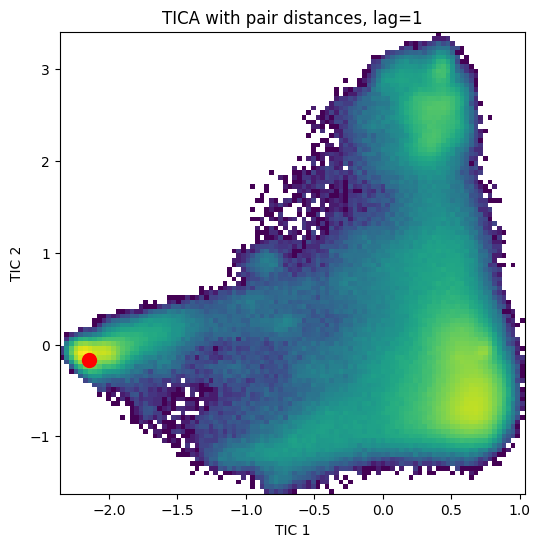

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

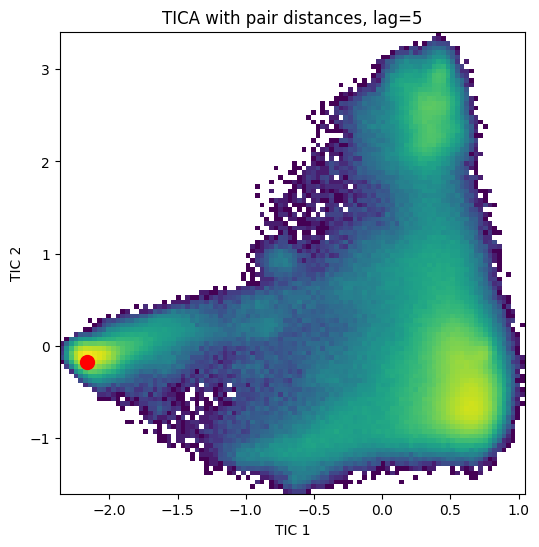

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

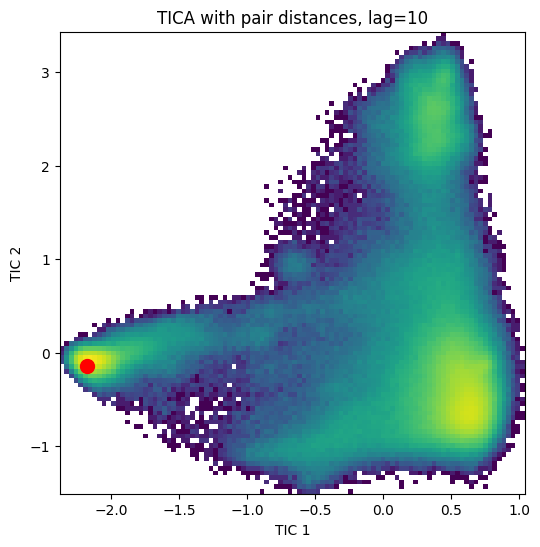

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

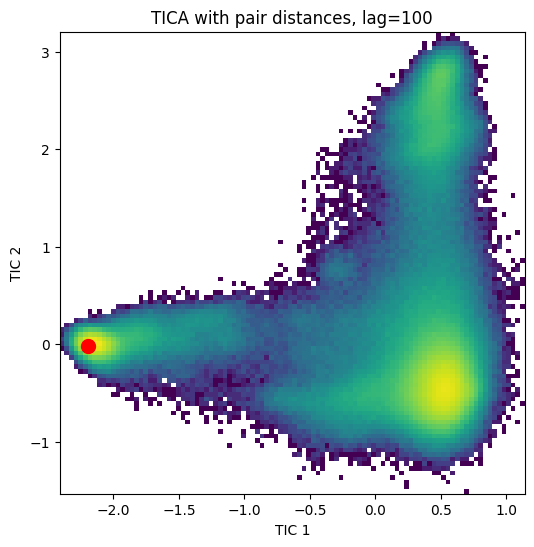

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

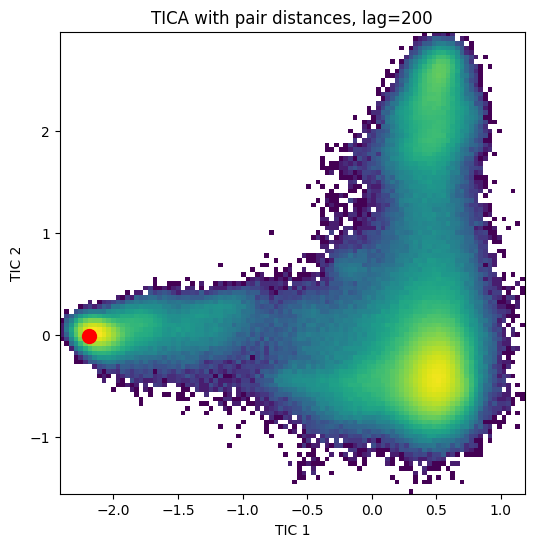

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

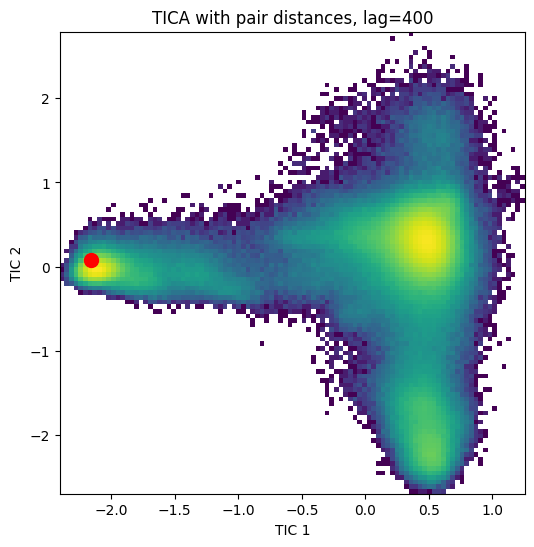

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

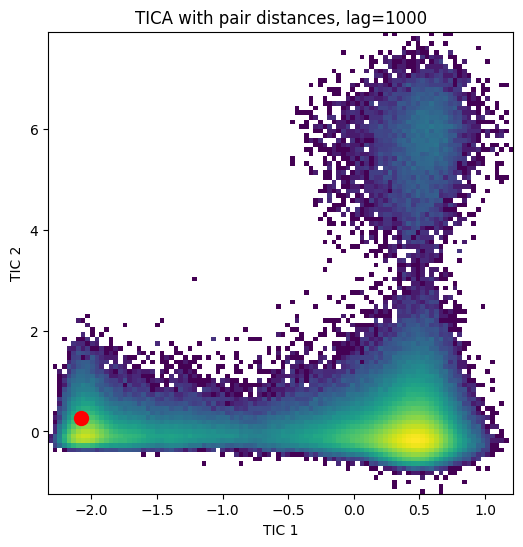

In [21]:
# TICA with pair distances
pdb_state = md.load(pdb_path)
pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)

for lag in (1, 5, 10, 100, 200, 400, 1000):
	data = ca_pair_contacts
	tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
	pdb_tica_x = pdb_tica_data[:, 0]
	pdb_tica_y = pdb_tica_data[:, 1]

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.scatter(pdb_tica_x, pdb_tica_y, color="red", s=100)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

# State by RMSD

## States

[  1  15  25  46  56  73  97 116 126 138 145 152 166 177 188 195 219 233
 247 261]
0.5568718


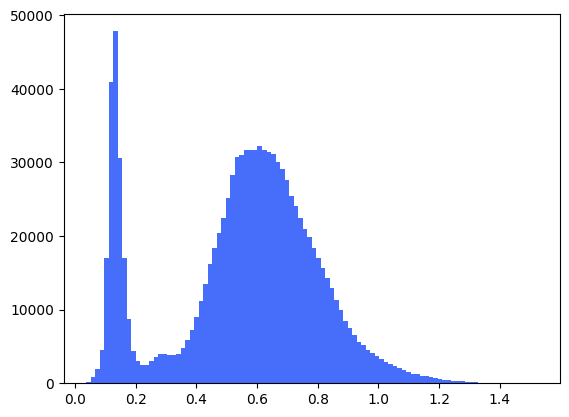

In [37]:
def label_by_rmsd(
	traj: md.Trajectory,
	reference_traj: md.Trajectory,
	atom_type: str = "ca",
) -> np.ndarray:
	"""
	Generate binary labels for folded/unfolded states based on RMSD
	"""
	if atom_type == "ca":
		atom_indices = traj.topology.select("name CA")
		print(atom_indices)
	else:
		atom_indices = None
	
	rmsd = md.rmsd(
		target = traj,
		reference = reference_traj,
		atom_indices = atom_indices
	)
	return rmsd

ref_pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/notebook/{molecule}_from_mae.pdb"
ref_pdb_traj = md.load_pdb(ref_pdb_path)
rmsd = label_by_rmsd(
    traj = all_traj,
    reference_traj = ref_pdb_traj,
)

print(rmsd.mean())
plt.hist(
    rmsd,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()

In [41]:
print(all_traj)
print(rmsd.shape)

# rmsd_to_folded_state = torch.from_numpy(rmsd)
# torch.save(
#     rmsd_to_folded_state,
#     f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/folded_state_rmsd_ca.pt"
# )

<mdtraj.Trajectory with 1044000 frames, 272 atoms, 20 residues, and unitcells>
(1044000,)


In [17]:
# TICA with pair distances

pdb_state = md.load(pdb_path)
lag = 5
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb_state.topology.residues), 2)]
)
data, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
tica_data = tica_obj.get_output()[0]
x = tica_data[:, 0]
y = tica_data[:, 1]

pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)
pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
pdb_tica_x = pdb_tica_data[:, 0]
pdb_tica_y = pdb_tica_data[:, 1]

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

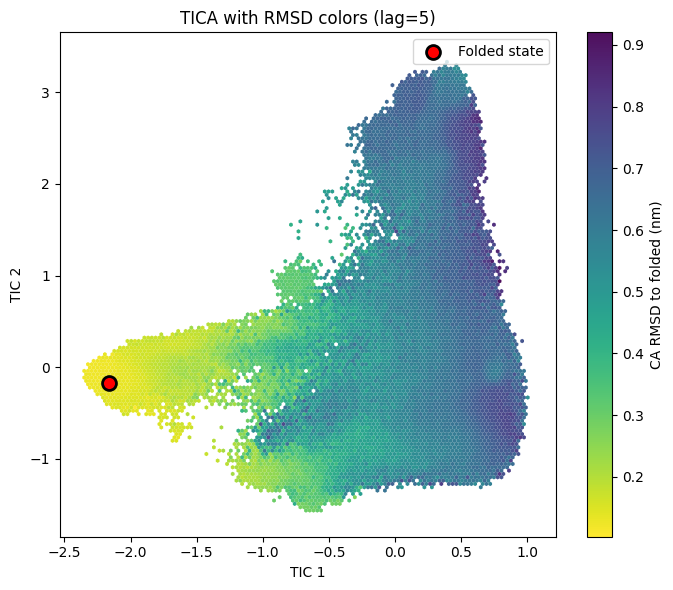

In [38]:
# Plot TICA with RMSD colors
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
sc = ax.hexbin(
	x, y,
	C=rmsd,
	gridsize=120,
	cmap='viridis_r',
	reduce_C_function=np.mean,
 	mincnt=3,
  	linewidths=0,
  	edgecolors="none",
   	alpha=0.95,
)
ax.scatter(
    pdb_tica_x,
    pdb_tica_y,
    c="red",
    s=100,
    edgecolors="k",
    linewidths=2,
    label="Folded state",
)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_title(f"TICA with RMSD colors (lag={lag})")
ax.legend(loc="best")
cb = plt.colorbar(sc, ax=ax)
cb.set_label("CA RMSD to folded (nm)")
plt.tight_layout()
plt.show()
plt.close()

In [63]:
folded_state_distance = label_distance.sum()
print("Foldedness by H bond distance")
print(f"Folded: {folded_state_distance} / {label_distance.shape[0]} ({folded_state_distance / label_distance.shape[0] * 100:.2f}%)")
print(f"Unfolded: {label_distance.shape[0] - folded_state_distance} / {label_distance.shape[0]} ({(label_distance.shape[0] - folded_state_distance) / label_distance.shape[0] * 100:.2f}%)")

folded_state_distance_angle = label_distance_angle.sum()
print("\nFoldedness by H bond distance and angle")
print(f"Folded: {folded_state_distance_angle} / {label_distance_angle.shape[0]} ({folded_state_distance_angle / label_distance_angle.shape[0] * 100:.2f}%)")
print(f"Unfolded: {label_distance_angle.shape[0] - folded_state_distance_angle} / {label_distance_angle.shape[0]} ({(label_distance_angle.shape[0] - folded_state_distance_angle) / label_distance_angle.shape[0] * 100:.2f}%)")

Foldedness by H bond distance
Folded: 410460 / 530000 (77.45%)
Unfolded: 119540 / 530000 (22.55%)

Foldedness by H bond distance and angle
Folded: 387679 / 530000 (73.15%)
Unfolded: 142321 / 530000 (26.85%)


In [ ]:
# torch.save(torch.from_numpy(label_distance), f"{save_dir}/{molecule}-{simulation_idx}-label_distance.pt")
# torch.save(torch.from_numpy(bond_num_distance), f"{save_dir}/{molecule}-{simulation_idx}-bond_num_distance.pt")
# torch.save(torch.from_numpy(label_distance_angle), f"{save_dir}/{molecule}-{simulation_idx}-label_distance_angle.pt")
# torch.save(torch.from_numpy(bond_num_distance_angle), f"{save_dir}/{molecule}-{simulation_idx}-bond_num_distance_angle.pt")